[//]: # ({% raw %})
<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar un corpus de anatomía y fisiología humana para crear embeddings de palabras basado en ese contexto. 

En este notebook se utilizarán los 3 volúmenes del libro "*General Anatomy applied to physiology and medicine*" de Xavier Bichat, los cuáles se obtienen en la página de [Project Gutenberg](https://www.gutenberg.org/ebooks/search/?query=GENERAL+ANATOMY+APPLIED+TO+PHYSIOLOGY+AND+MEDICINE&submit_search=Go%21).

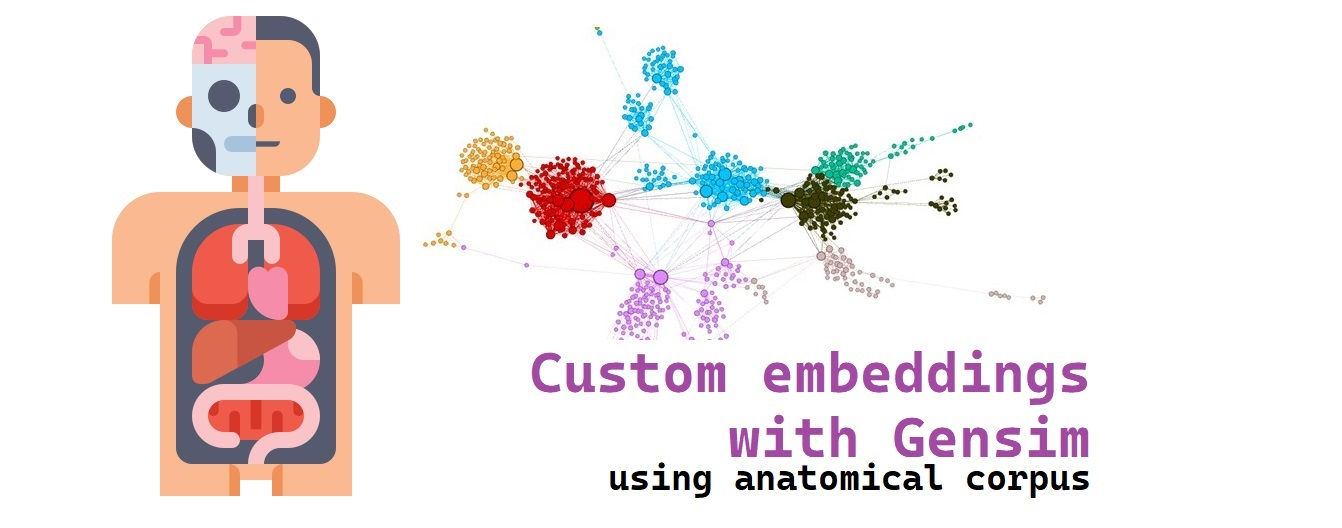

### Importo librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  

import multiprocessing
import re

import plotly.graph_objects as go
import plotly.express as px

from keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from urllib import request

from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE         

### Datos
Utilizaremos como dataset el vol. 1, 2 y 3 del libro "*General Anatomy applied to physiology and medicine*" de Xavier Bichat

In [2]:
# Descargo el eBook de Project Gutenberg
# URLs de los 3 volumenes del libro
url1 = "https://www.gutenberg.org/files/56118/56118-0.txt" # Vol 1
url2 = "https://www.gutenberg.org/files/56147/56147-0.txt" # Vol 2
url3 = "https://www.gutenberg.org/files/56328/56328-0.txt" # Vol 3

# Leo y uno los volúmenes, delimitados por start y end
texts = []
start = "*** START OF THIS PROJECT GUTENBERG EBOOK GENERAL ANATOMY"
end = "*** END OF THIS PROJECT GUTENBERG EBOOK GENERAL ANATOMY"

for url in [url1, url2, url3]:
    response = request.urlopen(url)
    raw = response.read()
    text = raw.decode("utf-8-sig")
    text = text[text.find(start) + len(start):text.find(end)]
    texts.append(text)

book = "\n".join(texts)

In [3]:
# Visualizo texto
book

', VOL 1 ***\r\n\r\n\r\n\r\n\r\nProduced by Sonya Schermann, Les Galloway and the Online\r\nDistributed Proofreading Team at http://www.pgdp.net (This\r\nfile was produced from images generously made available\r\nby The Internet Archive)\r\n\r\n\r\n\r\n\r\n\r\n\r\n[Illustration: BICHAT. X\r\n\r\n_Published by Richardson & Lord, Boston._]\r\n\r\n\r\n\r\n\r\n                           GENERAL ANATOMY,\r\n\r\n                              APPLIED TO\r\n\r\n                       PHYSIOLOGY AND MEDICINE;\r\n\r\n                           BY XAVIER BICHAT,\r\n\r\n       PHYSICIAN OF THE GREAT HOSPITAL OF HUMANITY AT PARIS, AND\r\n                 PROFESSOR OF ANATOMY AND PHYSIOLOGY.\r\n\r\n                      Translated from the French.\r\n\r\n                        BY GEORGE HAYWARD, M.D.\r\n\r\n         FELLOW OF THE AMERICAN ACADEMY OF ARTS AND SCIENCES,\r\n               AND OF THE MASSACHUSETTS MEDICAL SOCIETY.\r\n\r\n                       _IN THREE VOLUMES._\r\n\r\n               

### 1 - Preprocesamiento

In [4]:
# Filtro números, espacios en blanco consecutivos y caractéres especiales
filtered_text = re.sub(r'[^a-zA-z.!?/\"\'\s]', "", book)
filtered_text = re.sub(r"\s+", " ", filtered_text)
filtered_text = re.sub(r"[\_\[\]]", " ", filtered_text)
book = filtered_text.lower()

In [5]:
# Observo como queda el texto preprocesado
book

' vol produced by sonya schermann les galloway and the online distributed proofreading team at http//www.pgdp.net this file was produced from images generously made available by the internet archive  illustration bichat. x  published by richardson lord boston.   general anatomy applied to physiology and medicine by xavier bichat physician of the great hospital of humanity at paris and professor of anatomy and physiology. translated from the french. by george hayward m.d. fellow of the american academy of arts and sciences and of the massachusetts medical society.  in three volumes.  volume i.  boston  published by richardson and lord. j. h. a. frost printer. . district of massachusetts  to wit  district clerk\'s office. be it remembered that on the seventeenth day of april a. d. in the fortysixth year of the independence of the united states of america  richardson lord  of the said district have deposited in this office the title of a book the right whereof they claim as proprietors in

In [9]:
# Recorro todas las filas y transformo las oraciones en una secuencia de palabras
sentence_tokens = [text_to_word_sequence(row) for row in book.split(".")]
sentence_tokens[5000]

['the',
 'quantity',
 'of',
 'blood',
 'passing',
 'by',
 'the',
 'pulmonary',
 'artery',
 'was',
 'at',
 'first',
 'scarcely',
 'any',
 'thing',
 'because',
 'the',
 'dilatation',
 'of',
 'the',
 'ductus',
 'arteriosus',
 'was',
 'so',
 'great',
 'that',
 'it',
 'turned',
 'almost',
 'the',
 'whole',
 'of',
 'it',
 'into',
 'the',
 'descending',
 'aorta']

### 2 - Crear los vectores (word2vec)

Defino una clase de callback para poder informar el loss en cada época

In [10]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Creo el modelo generador de vectores utilizando `Word2Vec` utilizando la estructura modelo `skipgram`

In [11]:
w2v_model = Word2Vec(min_count=5,     # Frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,        # Cantidad de palabras antes y desp de la predicha
                     vector_size=50,  # Dimensionalidad de los vectores 
                     negative=20,     # Cantidad de negative samples... 0 es no se usa
                     workers=6,       
                     sg=1)            # modelo 0:CBOW  1:skipgram

Se crea el vocabulario con los tokens

In [12]:
w2v_model.build_vocab(sentence_tokens)

# Imprimo cantidad de documentos y el largo del vocabulario del corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)
print("Cantidad de palabras distintas en el corpus:", len(w2v_model.wv.key_to_index))

Cantidad de docs en el corpus: 19184
Cantidad de palabras distintas en el corpus: 3732


### 3 - Entrenar el modelo generador

Entreno el modelo con 150 épocas

In [31]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=150,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 407579.03125
Loss after epoch 1: 410535.03125
Loss after epoch 2: 394931.4375
Loss after epoch 3: 387954.375
Loss after epoch 4: 387706.875
Loss after epoch 5: 364515.25
Loss after epoch 6: 354194.75
Loss after epoch 7: 355940.5
Loss after epoch 8: 358705.0
Loss after epoch 9: 352167.75
Loss after epoch 10: 357738.5
Loss after epoch 11: 332228.5
Loss after epoch 12: 329763.5
Loss after epoch 13: 326992.5
Loss after epoch 14: 329302.5
Loss after epoch 15: 326016.5
Loss after epoch 16: 329195.0
Loss after epoch 17: 330500.5
Loss after epoch 18: 328393.5
Loss after epoch 19: 327432.0
Loss after epoch 20: 329178.5
Loss after epoch 21: 325889.5
Loss after epoch 22: 326153.0
Loss after epoch 23: 329071.0
Loss after epoch 24: 316221.0
Loss after epoch 25: 309926.0
Loss after epoch 26: 307671.0
Loss after epoch 27: 312744.0
Loss after epoch 28: 306865.0
Loss after epoch 29: 308212.0
Loss after epoch 30: 310191.0
Loss after epoch 31: 304209.0
Loss after epoch 32: 310431.0
Lo

(41038218, 62045550)

### 4 - Ensayar

In [14]:
# Palabras que se relacionan con "arteria":
w2v_model.wv.most_similar(positive=["artery"], topn=5)

[('aorta', 0.7570196986198425),
 ('vein', 0.7467379570007324),
 ('ventricle', 0.6669706702232361),
 ('trunks', 0.6493731737136841),
 ('auricle', 0.6452115774154663)]

La palabra **arteria** se relaciona con: aorta, vena, ventrículo, tronco y aurícula.

Se considera correcto, puesto que estas palabras verdaderamente tienen una relación fuerte. Por ejemplo, las venas también conducen sangre a través del cuerpo. Por otra parte, la aorta es la arteria principal del cuerpo. La palabra tronco probablemente proviene de *arterial trunk*, el cual es un defecto estructural de las arterias del corazón. Finalmente, el ventrículo y la aurícula son las cámaras del corazón que permiten bombear sangre hacia las arterias.

In [15]:
# Palabras que se relacionan con "secreción":
w2v_model.wv.most_similar(positive=["secretion"], topn=5)

[('exhalation', 0.7789068818092346),
 ('absorption', 0.7676805257797241),
 ('nutrition', 0.7068246603012085),
 ('excretion', 0.7007226943969727),
 ('secretions', 0.6563189625740051)]

La palabra **secreción** relaciona con: exhalación, absorción, nutrición, excreción y secreciones. 

En biología, se llama secreción al proceso por el que una célula o un ser vivo vierte al exterior sustancias que realizan su función fuera de la célula. Teniendo en cuenta esta definición, la exhalación también es un proceso en el que se empuja hacia el exterior una sustancia (el aire que respiramos). Por otro lado, la absorción y nutrición serían sus antónimos, mientras que la excreción es un sinónimo (eliminamos sustancias de desecho del cuerpo). Por último, secreciones es el plural de la palabra de entrada.

Por lo tanto, estas palabras verdaderamente tienen una relación fuerte.

In [16]:
# Palabras que se relacionan con "desarrollo":
w2v_model.wv.most_similar(positive=["development"], topn=5)

[('organization', 0.6870554089546204),
 ('formation', 0.6382623910903931),
 ('growth', 0.6228414177894592),
 ('production', 0.618486762046814),
 ('termination', 0.604915976524353)]

La palabra **desarrollo** relaciona con: organización, formación, crecimiento, producción y terminación.

En biología, el desarrollo estudia el proceso que origina los tejidos u órganos y la manera de cómo crecen y desarrollan organismos. Por lo tanto, se puede considerar a formación, crecimiento y producción como sinónimos. 

Por otro lado, en biología, organización se refiere a la jerarquía de estructuras que definen a la vida, lo cual tiene cierta relación en cuanto a que se debe seguir un orden jerárquico para lograr el desarrollo de un organismo (célula $\rightarrow$ tejido $\rightarrow$ órgano $\rightarrow$ sistema $\rightarrow$ organismo). Finalmente, terminación se puede relacionar con el estadío final del desarrollo, momento en el cual se termina.

In [23]:
# Palabras que se relacionan con "oxígeno":
w2v_model.wv.most_similar(positive=["oxygen"], topn=5)

[('air', 0.6734467148780823),
 ('hydrogen', 0.6578782796859741),
 ('atmospheric', 0.6555057764053345),
 ('purgatives', 0.6194542050361633),
 ('water', 0.6163737177848816)]

La palabra **oxígeno** se relaciona con: aire, hidrógeno, atmosférica, purgante, agua.

El aire, hidrógeno y agua son elementos que tienen bastante relación con el oxígeno. Por otro lado, el oxígeno que respiramos se encuentra presente en la atmósfera. Por último, un purgante es una preparación usada para provocar la defecación o la eliminación de heces y no encuentro una relación directa con la palabra de entrada.

In [210]:
# Palabras que se relacionan con "pequeño":
w2v_model.wv.most_similar(positive=["small"], topn=5)

[('great', 0.7135341167449951),
 ('large', 0.6439313292503357),
 ('considerable', 0.6320303082466125),
 ('several', 0.5859971046447754),
 ('certain', 0.5790355205535889)]

La palabra **pequeño** se relaciona con: grande, amplio, considerable, varios, ciertos. Son todas palabras que describen cantidades.

In [216]:
# Palabras que se relacionan con "piel":
w2v_model.wv.most_similar(positive=["skin"], topn=5)

[('epidermis', 0.6980447769165039),
 ('body', 0.6404324769973755),
 ('chorion', 0.6375656127929688),
 ('moisture', 0.5969803929328918),
 ('mucous', 0.5852730870246887)]

La palabra **piel** se relaciona con: epidermis, cuerpo, corion, humedad, mucosa. 

La epidermis es la capa exterior de la piel y el cuerpo se cubre de piel. El corion es la membrana más externa que rodea al embrión en desarrollo, por lo cual se puede interpretar como "piel del embrión". Finalmente, la humedad y mucosa son palabras que describen el aspecto de la piel en varias condiciones fisiológicas.

In [209]:
# Palabras que se relacionan con "sensible":
w2v_model.wv.most_similar(positive=["sensible"], topn=5)

[('insensible', 0.6526196002960205),
 ('augmented', 0.6082108020782471),
 ('manifest', 0.6015704870223999),
 ('sensibility', 0.5881972908973694),
 ('apparent', 0.5838631987571716)]

La palabra **sensible** se relaciona con: insensible, aumentado, manifiesto, sensibilidad, aparente.

La palabra insensible es su antónimo mientras que la palabra sensibilidad significa lo mismo. Esta se puede manifestar (manifiesto) o ser aparente para el médico. Finalmente, un paciente puede tener una sensibilidad aumentada.

In [211]:
# Palabras que se relacionan con "sangre":
w2v_model.wv.most_similar(positive=["blood"], topn=5)

[('chyle', 0.649969220161438),
 ('porta', 0.6310303211212158),
 ('red', 0.6286393404006958),
 ('circulation', 0.6271519660949707),
 ('lungs', 0.6159734725952148)]

La palabra **sangre** se relaciona con: quilo, porta, rojo, circulación, pulmones.

La palabra quilo se refiere a linfa que circula por los vasos quilíferos durante la digestión. Haciendo un análisis simple no comprendo cuál es la relación directa con sangre ni porqué es la palabra que **más** se relaciona. Por otro lado, la palabra porta proviene de vena porta, el vaso que transporta sangre hacia el higado. La palabra rojo describe el color de la sangre. La palabra circulación se relaciona puesto que la sangre circula por todo el cuerpo. Finalmente, la palabra pulmón se relaciona ya que es allí donde la sangre se oxigena.

#### Conclusiones

A simple vista, parece que las palabras tienen muy buena relación con aquellas que fueron dadas como entrada al modelo.
Al analizar cada grupo de palabras similares en particular, en la mayoría de los casos se puede encontrar alguna relación con la palabra de entrada. 

Se probaron muchas otras palabras pertenecientes al vocabulario, sin embargo, ninguna presentó una similitud coseno menor que 0,5. Por este motivo, se cree que los resultados son aceptables.


### 5 - Visualizar agrupación de vectores

In [226]:
def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

Grafico los embeddings en 2D

In [227]:
# Graficar los embedddings en 2D
x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show() 

A continuación, se muestran algunas agrupaciones con palabras que tienen cierta relación (son imágenes zoomed in del plot anterior):

- Números ordinales: primero (first), segundo (second), último (last)

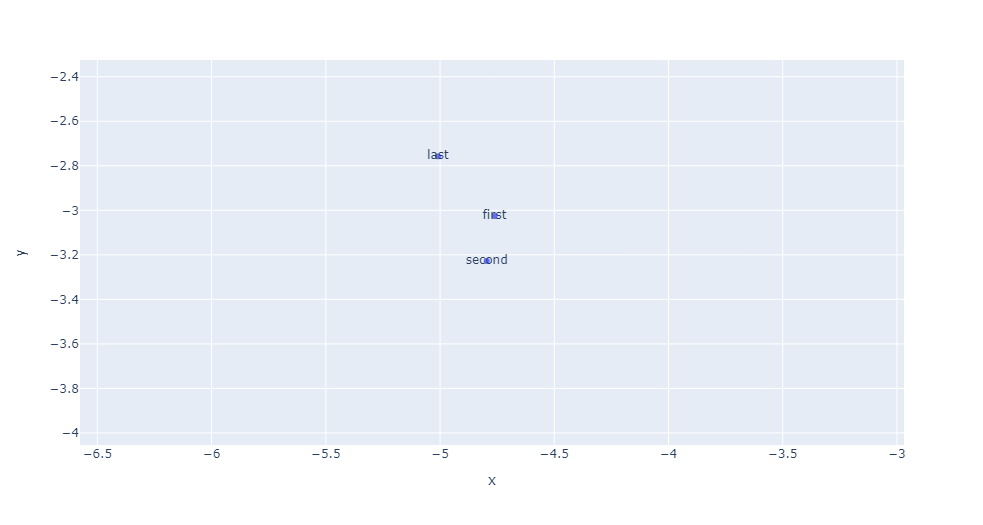

- Adverbios de cantidad: mucho (much), más (more), menos (less), mayor (greater), grande (great), pequeño (small)

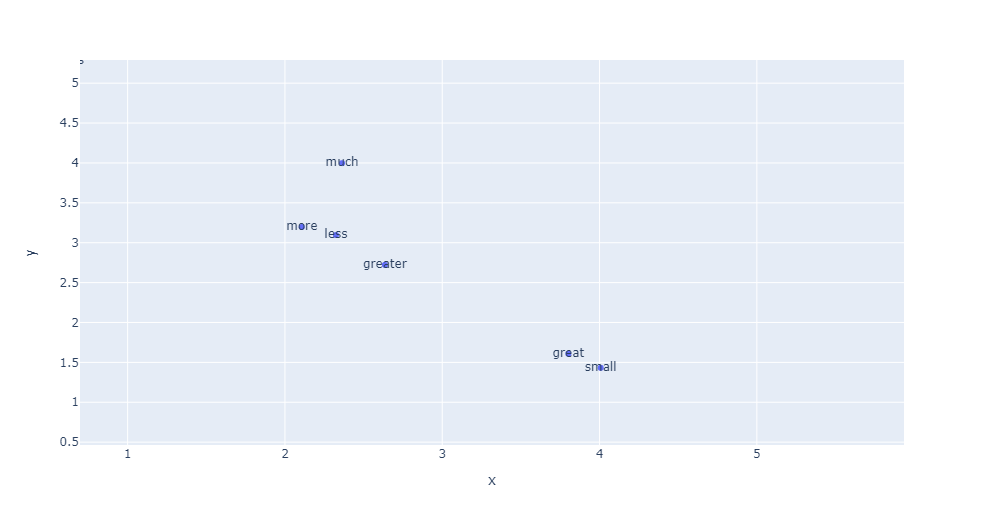

- Partes anatómicas del cuerpo: estómago (stomach), glándulas (glands), corazón (heart), arterias (arteries), venas (veins), vaso (vessels), músculos (muscles), nervios (nerves). 

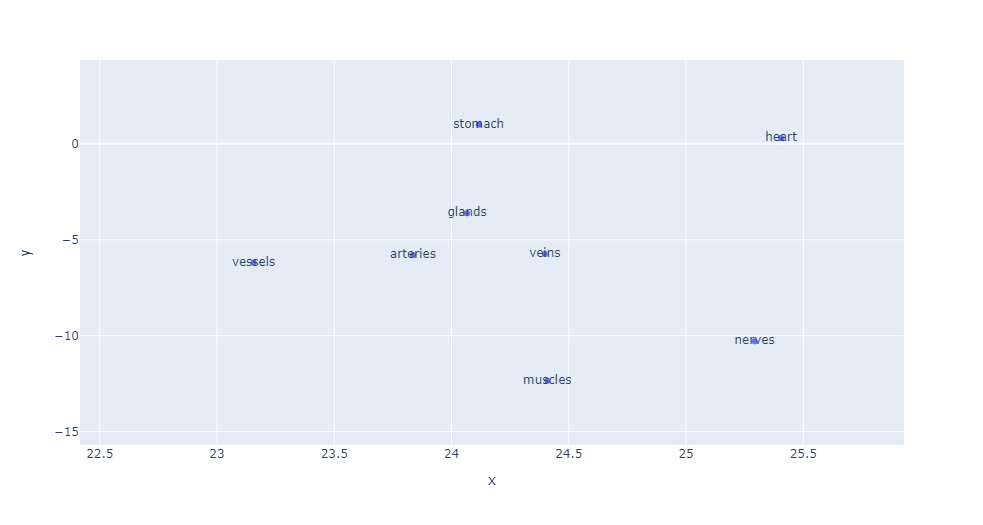

### 6 - Operaciones con embeddings 

A continuación, se prueban tres tests de analogía.

**1. Respiración = Pulmones + Exhalación**

Para respirar, requerimos exhalar el aire desoxigenado por medio de los pulmones. Como se puede observar, se obtiene la palabra propuesta con una similitud coseno de 0.72.

In [249]:
# Respiración = pulmones + exhalación (expulsión de aire)
result = w2v_model.wv.most_similar(positive=['lungs', 'exhalation'], topn=1)
print(result)

[('respiration', 0.7243947982788086)]


**2. Arteria = Vena + Oxígeno**

Las arterias transportan la sangre oxígenada mientras que las venas llevan la sangre desoxígenada. Por lo tanto, se puede pensar que que una arteria es equivalente a una vena que transporta oxígeno. Como se exhibe en la siguiente celda, la palabra obtenida es la que se pensó.

In [250]:
# Arteria = Vena + Oxígeno
result = w2v_model.wv.most_similar(positive=['veins', 'oxygen'], topn=1)
print(result)

[('arteries', 0.7153716683387756)]


**3. Cartílago = Hueso - Tensión**

Los huesos son organos duros, inelásticos y tensos, mientras que el cartílago es tejido conectivo suave, elástico y flexible.
Por lo tanto, se podría pensar una analógia en donde el cartílago es un hueso con menor tensión. El test dió la palabra propuesta, con una similitud coseno de 0,59.


In [92]:
# Cartilago = hueso - tension
result = w2v_model.wv.most_similar(positive=['bone'], negative= 'tension', topn=1)
print(result)

[('cartilage', 0.5890741348266602)]


[//]: # ({% endraw %})